<a href="https://colab.research.google.com/github/wadaka0821/nlp-tutorial/blob/main/questions/2_8_over_fitting_question.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 過学習の抑制（正則化）

作成者：和田  
最終更新日：2023/02/25

In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

In [ ]:
seed = 42
# Pytorchのシード値を固定
# 必要に応じてpythonやnumpyなどのシード値も固定する必要があります（再現性を持たせたい場合）
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# 使用可能なデバイスの確認
f'{device=}'

"device='cpu'"

以下の関数を学習させます
\begin{equation}
  y = sin(x)
\end{equation}

# 学習データの作成と確認

In [ ]:
train_data_num = 5
x = torch.empty((train_data_num, 1))
x = torch.Tensor.uniform_(x, 0, 2*torch.pi)

y = torch.sin(x.view(-1))

[Text(0.5, 1.0, 'sin(x)'), Text(0.5, 0, 'x'), Text(0, 0.5, 'y')]

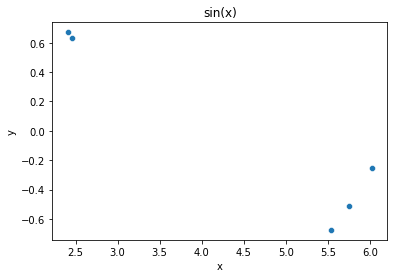

In [ ]:
sns.scatterplot(x=x.view(-1), y=y).set(title='sin(x)', xlabel='x', ylabel='y')

# モデルの定義

In [ ]:
class SimpleNN(torch.nn.Module):
  def __init__(self, in_dim=2, hidden_dim=2, out_dim=2):
    super(SimpleNN, self).__init__()

    self.hidden_layer1 = torch.nn.Linear(in_features=in_dim, out_features=hidden_dim)
    self.hidden_layer2 = torch.nn.Linear(in_features=hidden_dim, out_features=hidden_dim)
    self.hidden_layer3 = torch.nn.Linear(in_features=hidden_dim, out_features=hidden_dim)
    self.output_layer = torch.nn.Linear(in_features=hidden_dim, out_features=out_dim)

  def forward(self, x):
    h = torch.tanh(self.hidden_layer1(x))
    h = torch.tanh(self.hidden_layer2(h))
    h = torch.tanh(self.hidden_layer3(h))
    o = self.output_layer(h)

    return o

# 学習（正則化なし）

In [ ]:
MAX_EPOCH = 10000
lr = 1e-2

model = SimpleNN(in_dim=1, hidden_dim=50, out_dim=1)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr)

show_progress = False
for epoch in tqdm.tqdm(range(1, MAX_EPOCH+1)):
  optimizer.zero_grad(set_to_none=True)
  y_pred = model(x).view(-1)

  loss = torch.mean((y - y_pred)**2)
  loss.backward()

  optimizer.step()

  if show_progress:
    print(f'epoch : {epoch} | loss : {loss.item():.5f}')


100%|██████████| 10000/10000 [00:31<00:00, 313.29it/s]


## 問題1
---
↑の学習のコードでの損失を計算している部分について，
```python
loss = torch.mean((y - y_pred)**2)
```
この式で計算している損失は何と呼ばれる損失ですか？

 # 学習されたモデル

<AxesSubplot:>

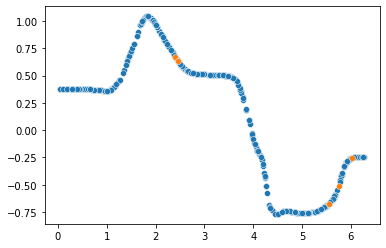

In [ ]:
n_sample = 500
sample_x = torch.empty((n_sample, 1))
sample_x = torch.Tensor.uniform_(sample_x, 0, 2*torch.pi)

with torch.no_grad():
  pred = model(sample_x).view(-1)

sns.scatterplot(x=sample_x.view(-1), y=pred)
sns.scatterplot(x=x.view(-1), y=y)

# 学習（正則化あり）

In [ ]:
MAX_EPOCH = 10000
lr = 1e-2
alpha = 0.001

model = SimpleNN(in_dim=1, hidden_dim=50, out_dim=1)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr)

show_progress = False
for epoch in tqdm.tqdm(range(1, MAX_EPOCH+1)):
  optimizer.zero_grad(set_to_none=True)
  y_pred = model(x).view(-1)

  loss = torch.mean((y - y_pred)**2)
  for param in model.parameters():
    loss += alpha*(torch.linalg.norm(param)**2)
  loss.backward()

  optimizer.step()

  if show_progress:
    print(f'epoch : {epoch} | loss : {loss.item():.5f}')

100%|██████████| 10000/10000 [00:24<00:00, 400.46it/s]


<AxesSubplot:>

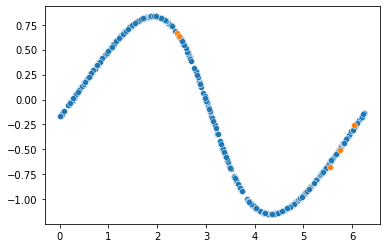

In [ ]:
n_sample = 500
sample_x = torch.empty((n_sample, 1))
sample_x = torch.Tensor.uniform_(sample_x, 0, 2*torch.pi)

with torch.no_grad():
  pred = model(sample_x).view(-1)

sns.scatterplot(x=sample_x.view(-1), y=pred)
sns.scatterplot(x=x.view(-1), y=y)

## 問題2
---
1. 今回は L2 Loss を使用して過学習の抑制を行いました．ほかにも過学習の抑制方法は存在します．いくつかの過学習の抑制方法について調べてください．
1. (出来たらでOK)上で調べた過学習の抑制方法によってモデルの学習(モデル自体の構造を変更してもOK)を行ってください